<a href="https://colab.research.google.com/github/SayantikaFSU/ocp-ci-analysis/blob/master/TitanicDataSet_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240518%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240518T153328Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D775dcef7eefad63d1d914b5aa5845ef5642af29e5b8dd2cf2b93faa6b6d712ce3db8d80ed387d42520c5b70fda9e566c03682033fb65e220a1da6cdb256675ccafcd3a1486ac675115205572c683aeb05180f730c2be3bbe3027beb4b5e3b5bea79ffeb775cd43e2b39bb2647896c0795194bcb385783950093c3b156e9bd33f11a3c2e561aef1af4dc5e85872f9e020f823b4401a0a18027f97470715b6bd3515c08c5dbb757926e467b4669bc3039ab8599c56399e36dd25016d13a3004cf3d338405a968280564dad71024c7cc429267b988789443ca8b8f5ebddc16f8ea7e82652a3623e38b5397429c996fba08fec4c8a4e53e9cfb20ccdca7d7eeddd68'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: titanic
Data source import complete.


In [2]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
import re

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

This notebook deals with the Titanic Data Set available in the Kaggle platform.
Goal : to predict the Survival Percentage of each passenger. The result consists of the passegenID and the survival % in each case of the "test.csv".

**********************************************************************************

Section: INTIAL DATA ANALYSIS
*************************************************************

In [3]:
import pandas as pd

test= pd.read_csv('/kaggle/input/titanic/test.csv')
train= pd.read_csv('/kaggle/input/titanic/train.csv')
#print(train.head(2),test.head(2))
print(train.shape)
#print(train.columns)
#print(train.head(5))
print(train.info())


print(test.info())

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64 

In [4]:
#find categorical columns:

# Find categorical columns
categorical_columns = train.select_dtypes(include='object').columns

# Print the list of categorical columns
print("Categorical columns:")
print(categorical_columns)



# Print unique categories in each categorical column
for column in categorical_columns:
    unique_categories = train[column].unique()
    #print(f"\n Unique categories in '{column}': \n {unique_categories}    Length= {len(unique_categories)}")
    print(f"\n Unique categories in '{column}'      Length= {len(unique_categories)}")
    print()

Categorical columns:
Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

 Unique categories in 'Name'      Length= 891


 Unique categories in 'Sex'      Length= 2


 Unique categories in 'Ticket'      Length= 681


 Unique categories in 'Cabin'      Length= 148


 Unique categories in 'Embarked'      Length= 4



In [5]:
# Find row indexes with NaN values: Train Set:

rows_with_nan = train[train.isna().any(axis=1)].index

# Print the row indexes
print("Row indexes with NaN values:",rows_with_nan)




Row indexes with NaN values: Index([  0,   2,   4,   5,   7,   8,   9,  12,  13,  14,
       ...
       878, 880, 881, 882, 883, 884, 885, 886, 888, 890],
      dtype='int64', length=708)


In [6]:
# columns with nan values: Train Set:

# Set the threshold for missing values:
threshold = 0
# Calculate the percentage of missing values for each column
missing_percentage = train.isnull().mean()

# Identify columns with missing values exceeding the threshold
columns_with_high_missing_values = missing_percentage[missing_percentage > threshold].index

# Print the column names
print(f"{len(columns_with_high_missing_values)} Columns have {threshold*100}% or more missing values, Column names-- \n",columns_with_high_missing_values)


3 Columns have 0% or more missing values, Column names-- 
 Index(['Age', 'Cabin', 'Embarked'], dtype='object')


In [7]:
# columns with nan values: Test Set:

# Set the threshold for missing values:
threshold = 0
# Calculate the percentage of missing values for each column
missing_percentage = test.isnull().mean()

# Identify columns with missing values exceeding the threshold
columns_with_high_missing_values = missing_percentage[missing_percentage > threshold].index

# Print the column names
print(f"{len(columns_with_high_missing_values)} Columns have {threshold*100}% or more missing values, Column names-- \n",columns_with_high_missing_values)


3 Columns have 0% or more missing values, Column names-- 
 Index(['Age', 'Fare', 'Cabin'], dtype='object')


In [8]:
# Find the row numbers with NAN values in a particular column : Train Set

column_name = 'Embarked'

# Create a boolean mask for NaN values in the specified column
nan_mask = train[column_name].isna()

# Use the boolean mask to get the row numbers with NaN values
rows_with_nan = train[nan_mask].index.tolist()

# Print the row numbers
print("Rows with NaN values in '{}' column: {}".format(column_name, rows_with_nan))
print(len(rows_with_nan))

Rows with NaN values in 'Embarked' column: [61, 829]
2


In [9]:
# Find the row numbers with NAN values in a particular column : Test Set

column_name = 'Cabin'

# Create a boolean mask for NaN values in the specified column
nan_mask = test[column_name].isna()

# Use the boolean mask to get the row numbers with NaN values
rows_with_nan = test[nan_mask].index.tolist()

# Print the row numbers
#print("Rows with NaN values in '{}' column: {}".format(column_name, rows_with_nan))
#print(len(rows_with_nan))


#fill nan with 0:



test['Age'] = test['Age'].fillna(0)
test['Fare']=test['Fare'].fillna(0)
test['Cabin']=test['Cabin'].fillna(0)

In [10]:
# Drop rows with NaN values in the specified column
train_cleaned = train.dropna(subset=['Embarked'])

# Print the cleaned DataFrame
print("DataFrame after dropping rows with NaN values in '{}' column:".format(column_name))
print(train_cleaned.shape)

DataFrame after dropping rows with NaN values in 'Cabin' column:
(889, 12)


So the rest of the notebook deals with 'train_cleaned' instead of train from now on.
*************************************************************************************


In [11]:
data=train_cleaned
data.shape

(889, 12)

In [12]:
data_test=test
test.shape

(418, 11)

Section: FEATURE ENGGENEERING
**************************************************

 (1) I have converted the categorical values to numeric values

 (2) Combined few columns to form one, maintaining the information

 (3) Introduced new predictor which might prove useful



In [13]:
# (1) convert Sex to numeric:
data['Sex'] = data['Sex'].map({'male': 1, 'female': 0})

print(data.shape)

data_test['Sex'] = data_test['Sex'].map({'male': 1, 'female': 0})
print(data_test.shape)

(889, 12)
(418, 11)


In [14]:
#(2)set embarked to S if not stated then set to numeric
data['Embarked'] = data['Embarked'].fillna('S')
data['Embarked'] = data['Embarked'].map({'Q': 2, 'S': 1, 'C': 0})

print(data.shape)



data_test['Embarked'] = data_test['Embarked'].fillna('S')
data_test['Embarked'] = data_test['Embarked'].map({'Q': 2, 'S': 1, 'C': 0})

print(data_test.shape)

(889, 12)
(418, 11)


In [15]:
#(3)add feature that tells whether a passenger had a cabin on the Titanic

data['Has_Cabin'] = data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

data.head(2)


data_test['Has_Cabin'] = data_test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,2,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,1,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,2,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,0.0,0,0,A.5. 3236,8.0500,0,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,1,1
416,1308,3,"Ware, Mr. Frederick",1,0.0,0,0,359309,8.0500,0,1,1


In [16]:
# (4)Create new feature FamilySize as a combination of SibSp and Parch
data['Family_Size'] = data['SibSp'] + data['Parch'] + 1
data

data_test['Family_Size'] = data_test['SibSp'] + data_test['Parch'] + 1
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Family_Size
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,2,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,1,1,2
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,2,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,0.0,0,0,A.5. 3236,8.0500,0,1,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,0,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,1,1,1
416,1308,3,"Ware, Mr. Frederick",1,0.0,0,0,359309,8.0500,0,1,1,1


In [17]:
# (5)Create new feature IsAlone from FamilySize
data['IsAlone'] = 0
data.loc[data['Family_Size'] == 1, 'IsAlone'] = 1
data


data_test['IsAlone'] = 0
data_test.loc[data_test['Family_Size'] == 1, 'IsAlone'] = 1
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Family_Size,IsAlone
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,0,2,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,0,1,1,2,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,0,2,1,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,0,1,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,0,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,0.0,0,0,A.5. 3236,8.0500,0,1,1,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,0,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,0,1,1,1,1
416,1308,3,"Ware, Mr. Frederick",1,0.0,0,0,359309,8.0500,0,1,1,1,1


In [18]:
#find quantiles of the column 'Fare'


column_name = 'Fare'

# Specify the quantiles you want to calculate (e.g., 25%, 50%, 75%)
quantiles = [0.25, 0.5, 0.75]

# Use the quantile function to calculate quantiles for the specified column
column_quantiles = data[column_name].quantile(quantiles)

# Print the quantiles
print("Quantiles for '{}' column:".format(column_name))
print(column_quantiles)


Quantiles for 'Fare' column:
0.25     7.8958
0.50    14.4542
0.75    31.0000
Name: Fare, dtype: float64


In [19]:
#(6) Fare Bins pushed into 4 quantiles

data.loc[ data['Fare'] <= 7.91, 'Fare'] = 0
data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
data.loc[ data['Fare'] > 31, 'Fare']  = 3
data['Fare'] = data['Fare'].astype(int)

data






data_test.loc[ data_test['Fare'] <= 7.91, 'Fare'] = 0
data_test.loc[(data_test['Fare'] > 7.91) & (data_test['Fare'] <= 14.454), 'Fare'] = 1
data_test.loc[(data_test['Fare'] > 14.454) & (data_test['Fare'] <= 31), 'Fare']   = 2
data_test.loc[ data_test['Fare'] > 31, 'Fare']  = 3
data_test['Fare'] = data_test['Fare'].astype(int)

data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Family_Size,IsAlone
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,0,0,2,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,0,0,1,1,2,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,1,0,2,1,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,1,0,1,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,1,0,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,0.0,0,0,A.5. 3236,1,0,1,1,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,3,C105,0,1,1,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,0,0,1,1,1,1
416,1308,3,"Ware, Mr. Frederick",1,0.0,0,0,359309,1,0,1,1,1,1


In [20]:
# (7):Create a new feature Title, containing the titles of passenger names. Replace rare titles with "rare"
#replace and fix miss spellings
#map str to intergrers and fill none with 0


def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return

get_title(data['Name'][0])


'Mr'

In [21]:
data['Title'] = data['Name'].apply(get_title)
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data['Title'] = data['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
data['Title'] = data['Title'].fillna(0)

data





data_test['Title'] = data_test['Name'].apply(get_title)
data_test['Title'] = data_test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data_test['Title'] = data_test['Title'].replace('Mlle', 'Miss')
data_test['Title'] = data_test['Title'].replace('Ms', 'Miss')
data_test['Title'] = data_test['Title'].replace('Mme', 'Mrs')
data_test['Title'] = data_test['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
data_test['Title'] = data_test['Title'].fillna(0)

data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Family_Size,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,0,0,2,1,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,0,0,1,1,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,1,0,2,1,1,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,1,0,1,1,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,1,0,1,1,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,0.0,0,0,A.5. 3236,1,0,1,1,1,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,3,C105,0,1,1,1,5
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,0,0,1,1,1,1,1
416,1308,3,"Ware, Mr. Frederick",1,0.0,0,0,359309,1,0,1,1,1,1,1


In [22]:
#(8) Replace NAN age with 0
column_name = 'Age'
target_value = '0'

# Create a boolean mask for rows where the specified column has the target value
rows_with_target_value = data[data[column_name] == target_value].index.tolist()

# Print the row numbers
print("Rows with '{}' value in '{}' column:".format(target_value, column_name))
print(rows_with_target_value)


Rows with '0' value in 'Age' column:
[]


In [23]:

column_name = 'Age'

# Replace NaN values with 0 in 'Age'
data[column_name] = data[column_name].fillna(0)

# Print the DataFrame after the replacement
print("DataFrame after replacing NaN values with 0 in '{}' column:".format(column_name))
#print(data)
data.columns


DataFrame after replacing NaN values with 0 in 'Age' column:


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Has_Cabin',
       'Family_Size', 'IsAlone', 'Title'],
      dtype='object')

DATA MODELs: PREDICT THE SURVIVAL PERCENTAGE

In this section we are viewing it as a regression problem and trying to predict the percentage of survival based on the predictor columns.

We have not used Unsupervised Learning models because of that.
**********************************************************************

In [24]:
predictor_columns=[ 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_Cabin',
       'IsAlone', 'Title']
response_column=['Survived']

X=data[predictor_columns]
Y=data[response_column]

X.shape, Y.shape

((889, 8), (889, 1))

In [25]:
# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


Multicollinearity:

Before embarking on the journey of finding the best regression model for our puropose we decided to check on the multicollinearity aspect between the variables involved.

**************************************************************************************


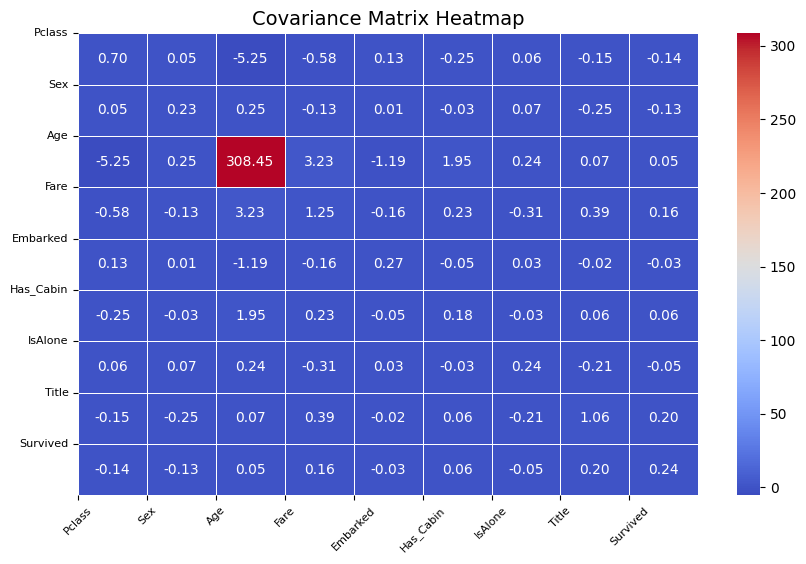

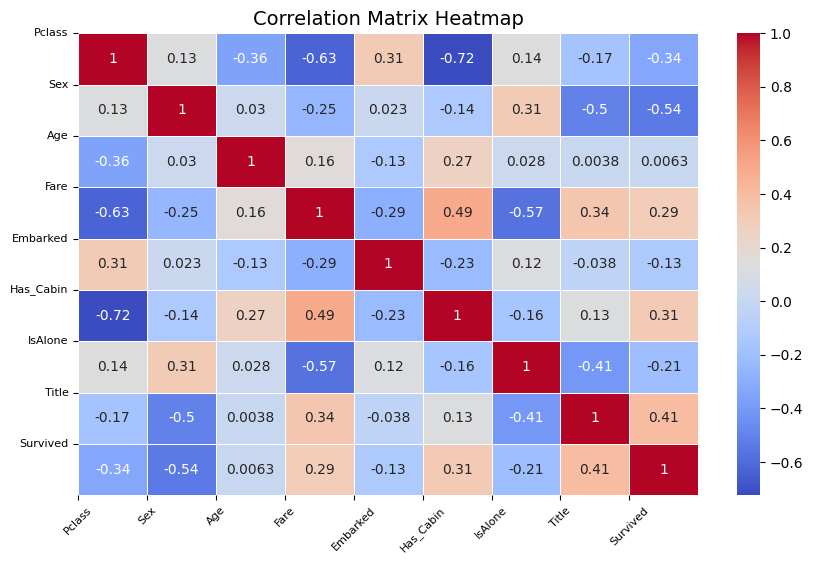

In [26]:
# form a heat plot

import seaborn as sns
import matplotlib.pyplot as plt

train_data=data[['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_Cabin',
       'IsAlone', 'Title','Survived']]

# Calculate the covariance matrix:
cov_matrix = np.cov(train_data, rowvar=False)

# Create a heatmap of the covariance matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cov_matrix, annot=True, fmt="0.2f",cmap='coolwarm', linewidths=0.5)

#sns.heatmap(cov_matrix, annot=False, fmt="0.2f",cmap='coolwarm', linewidths=0.5)

# Set the title
plt.title('Covariance Matrix Heatmap',fontsize= 14)

# Customize tick labels
plt.xticks(np.arange(len(train_data.columns)), train_data.columns, rotation=45,fontsize=8)
plt.yticks(np.arange(len(train_data.columns)), train_data.columns, rotation=0,fontsize=8)

# Show the plot
plt.show()

## Correlation Matrix:
correlation_matrix = train_data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set the title
plt.title('Correlation Matrix Heatmap',fontsize= 14)

# Customize tick labels
plt.xticks(np.arange(len(train_data.columns)), train_data.columns, rotation=45,fontsize=8)
plt.yticks(np.arange(len(train_data.columns)), train_data.columns, rotation=0,fontsize=8)

# Show the plot
plt.show()

Model 1: Multiple Linear Regression
**************************************************************************

In [27]:
## Multiple Linear regression
import statsmodels.api as sm

# Add a constant term to the independent variables (intercept)
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(Y, X).fit()

# Get the summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     72.11
Date:                Sat, 18 May 2024   Prob (F-statistic):           4.17e-91
Time:                        15:34:13   Log-Likelihood:                -395.87
No. Observations:                 889   AIC:                             809.7
Df Residuals:                     880   BIC:                             852.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9237      0.111      8.295      0.0

In [28]:
## Removing the varibales whose p-value>0.05: Backward Elimination

while model.pvalues.max() > 0.05:
    variable_to_remove = model.pvalues.idxmax()
    X = X.drop(variable_to_remove,axis=1)
    model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     114.0
Date:                Sat, 18 May 2024   Prob (F-statistic):           5.43e-93
Time:                        15:34:13   Log-Likelihood:                -398.56
No. Observations:                 889   AIC:                             809.1
Df Residuals:                     883   BIC:                             837.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8548      0.081     10.595      0.0

In [29]:
## MSE
from sklearn.metrics import mean_squared_error
Yhat=model.predict(X)
mse_OLS=mean_squared_error(Yhat,Y)

print(f'mse for multiple regression model={mse_OLS:0.3f}')

mse for multiple regression model=0.144


Model 2: Random Forrest with Recursive Feature elimination:
*********************************************************************

In [30]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_selection import RFECV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [31]:
from sklearn.ensemble import RandomForestRegressor


# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create an RFE model
rfe = RFECV(estimator=rf_model, step=1, cv=5)
rfe.fit(X_train, Y_train)

# Get the optimal number of features
optimal_num_features = rfe.n_features_
print("Optimal Number of Features:", optimal_num_features)

# Print the selected features
selected_features = pd.DataFrame({'Feature': X.columns, 'Selected': rfe.support_, 'Ranking': rfe.ranking_})
print("Selected Features:")
print(selected_features)

# Transform the data to include only the selected features
X_train_selected = rfe.transform(X_train)
X_val_selected = rfe.transform(X_val)

# Now, you can train a model with the selected features
rf_model.fit(X_train_selected, Y_train)


# Make predictions on the validation set
Y_pred_selected = rf_model.predict(X_val_selected)

# Evaluate the model's performance
accuracy = accuracy_score(Y_val, Y_pred_selected)
print("Accuracy:", accuracy)

 #Calculate Mean Squared Error
mse_selected = mean_squared_error(Y_val, Y_pred_selected)

print(f"Mean Squared Error with selected features:{mse_selected:0.3f}")

rf_selected_feature=selected_features.loc[selected_features['Ranking']==1,'Feature']
rf_selected_feature

Optimal Number of Features: 4
Selected Features:
     Feature  Selected  Ranking
0      const     False        3
1     Pclass      True        1
2        Sex      True        1
3        Age      True        1
4  Has_Cabin     False        2
5      Title      True        1
Accuracy: 0.8258426966292135
Mean Squared Error with selected features:0.174


1    Pclass
2       Sex
3       Age
5     Title
Name: Feature, dtype: object

Model 3: Feature Selection with SVM:
**************************************************

In [32]:

from sklearn.svm import SVR


# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


# Create an SVM Regressor model
svm_model = SVR(kernel='linear')  # You can choose different kernels based on your data characteristics


# Create an RFE model
rfe = RFECV(estimator=svm_model, step=1, cv=5)
rfe.fit(X_train, Y_train)

# Get the optimal number of features
optimal_num_features = rfe.n_features_
print("Optimal Number of Features:", optimal_num_features)

# Print the selected features
selected_features = pd.DataFrame({'Feature': X.columns, 'Selected': rfe.support_, 'Ranking': rfe.ranking_})
print("Selected Features:")
print(selected_features)

# Transform the data to include only the selected features
X_train_selected = rfe.transform(X_train)
X_val_selected = rfe.transform(X_val)

# Now, you can train a model with the selected features
rf_model.fit(X_train_selected, Y_train)


# Make predictions on the validation set
Y_pred_selected = rf_model.predict(X_val_selected)

# Evaluate the model's performance
accuracy = accuracy_score(Y_val, Y_pred_selected)
print("Accuracy:", accuracy)

 #Calculate Mean Squared Error
mse_selected = mean_squared_error(Y_val, Y_pred_selected)

print(f"Mean Squared Error with selected features:{mse_selected:0.3f}")


svm_selected_feature=selected_features.loc[selected_features['Ranking']==1,'Feature']
svm_selected_feature

Optimal Number of Features: 5
Selected Features:
     Feature  Selected  Ranking
0      const     False        2
1     Pclass      True        1
2        Sex      True        1
3        Age      True        1
4  Has_Cabin      True        1
5      Title      True        1
Accuracy: 0.8258426966292135
Mean Squared Error with selected features:0.174


1       Pclass
2          Sex
3          Age
4    Has_Cabin
5        Title
Name: Feature, dtype: object

Model (6): XGBoost with Feature Selection
**********************************************************************

In [33]:
from xgboost import XGBRegressor

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create and train the XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Create an RFE model
rfe = RFECV(estimator=xgb_model, step=1, cv=5)
rfe.fit(X_train, Y_train)

# Get the optimal number of features
optimal_num_features = rfe.n_features_
print("Optimal Number of Features:", optimal_num_features)

# Print the selected features
selected_features = pd.DataFrame({'Feature': X.columns, 'Selected': rfe.support_, 'Ranking': rfe.ranking_})
print("Selected Features:")
print(selected_features)

# Transform the data to include only the selected features
X_train_selected = rfe.transform(X_train)
X_val_selected = rfe.transform(X_val)

# Now, you can train a model with the selected features
rf_model.fit(X_train_selected, Y_train)


# Make predictions on the validation set
Y_pred_selected = rf_model.predict(X_val_selected)

# Evaluate the model's performance
accuracy = accuracy_score(Y_val, Y_pred_selected)
print("Accuracy:", accuracy)

 #Calculate Mean Squared Error
mse_selected = mean_squared_error(Y_val, Y_pred_selected)

print(f"Mean Squared Error with selected features:{mse_selected:0.3f}")



xgb_selected_feature=selected_features.loc[selected_features['Ranking']==1,'Feature']
xgb_selected_feature

Optimal Number of Features: 4
Selected Features:
     Feature  Selected  Ranking
0      const     False        3
1     Pclass      True        1
2        Sex      True        1
3        Age     False        2
4  Has_Cabin      True        1
5      Title      True        1
Accuracy: 0.8033707865168539
Mean Squared Error with selected features:0.197


1       Pclass
2          Sex
4    Has_Cabin
5        Title
Name: Feature, dtype: object

Section: Model Selection and Hypertune:
********************************************************************************************************

(1) Random Forrest Regressor : optimal_features =4  MSE=0.174

(2) SVR : optimal_fetaures =5, MSE=0.174

(3) XGBOOST: optimal_feature =4, MSE =0.174


So we went ahead and hypertuned Random Forrest Regressor:



In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV


X_rf=data[rf_selected_feature]


# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_rf, Y, test_size=0.2, random_state=42)

# Create the Random Forest Classifier model
rf_model = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the Random Forest model with the best hyperparameters on the selected features
best_rf_model = RandomForestRegressor(**best_params)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_val)

# Evaluate the model

mse_rf=mean_squared_error(y_val,y_pred)

print("Best Hyperparameters:", best_params)
print(f"MSE for best RF model={mse_rf:0.3f}")

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
MSE for best RF model=0.148


In [38]:
best_rf_model

RandomForestRegressor(n_estimators=50)

In [35]:
"""
# Save the model
import joblib

joblib.dump(best_rf_model, 'best_rf_model.joblib')



['best_rf_model.joblib']

Section: Applying the final_model on the test data set:
*********************************************************************************

In [36]:
Xt=data_test[rf_selected_feature]
Xt.columns

Index(['Pclass', 'Sex', 'Age', 'Title'], dtype='object')

In [39]:
"""
import joblib

# Load the model
loaded_model = joblib.load('/kaggle/working/best_rf_model.joblib')

"""
loaded_model=best_rf_model

In [40]:
loaded_model.fit(X_rf,Y)
Yt=loaded_model.predict(Xt)

In [41]:
response_column_test='% Survived'

data_test['% Survived']=Yt

data_test

result=data_test[['PassengerId','% Survived']]

In [42]:
print('Selected features: \n',rf_selected_feature)
result

Selected features: 
 1    Pclass
2       Sex
3       Age
5     Title
Name: Feature, dtype: object


,PassengerId,% Survived
0,892,0.000000
1,893,0.000000
2,894,0.680000
3,895,0.672333
4,896,0.920095
...,...,...
413,1305,0.077877
414,1306,0.680000
415,1307,0.003333
416,1308,0.077877


Pictorial representation of the result:
********************************************************

In [43]:
#find quantiles of the column 'Fare'


column_name = '% Survived'

# Specify the quantiles you want to calculate (e.g., 25%, 50%, 75%)
quantiles = [0.25, 0.5, 0.75]

# Use the quantile function to calculate quantiles for the specified column
column_quantiles = result[column_name].quantile(quantiles)

# Print the quantiles
print("Quantiles for '{}' column:".format(column_name))
print(column_quantiles)


Quantiles for '% Survived' column:
0.25    0.077877
0.50    0.241185
0.75    0.710864
Name: % Survived, dtype: float64


In [44]:
# %Survived pushed into 4 quantiles
q1=0.072782
q2=0.253258
q3=0.682286


count_quantile_1=((result['% Survived'] >= 0) & (result['% Survived'] <= q1)).sum()
count_quantile_2=((result['% Survived'] >= q1) & (result['% Survived'] <= q2)).sum()
count_quantile_3=((result['% Survived'] >= q2) & (result['% Survived'] <= q3)).sum()
count_quantile_4=((result['% Survived'] >= q3)).sum()


print(count_quantile_1,count_quantile_2,count_quantile_3,count_quantile_4)





96 120 93 109


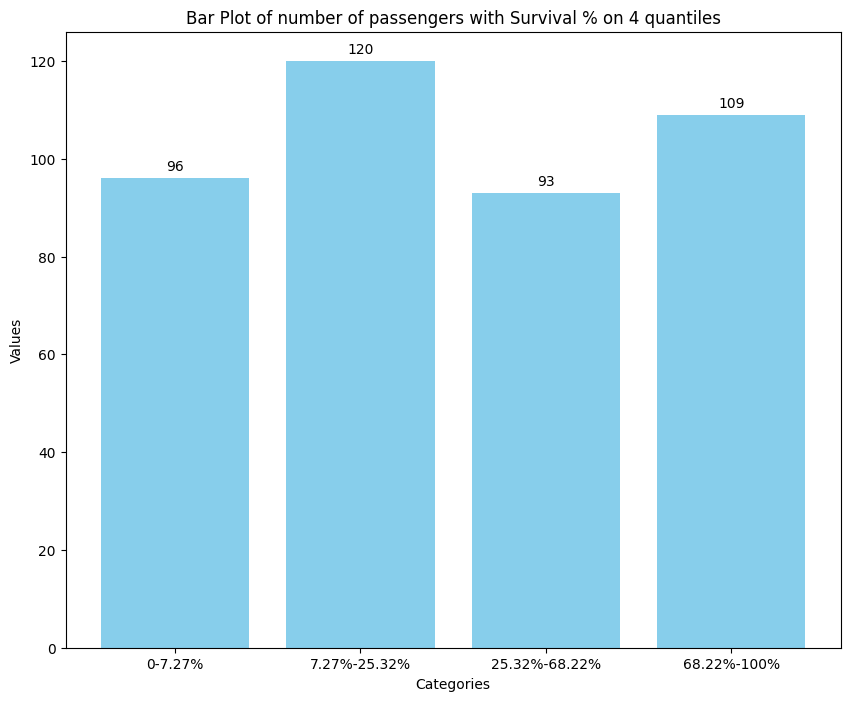

In [45]:
import matplotlib.pyplot as plt


# Count the occurrences of each category
counts = [count_quantile_1,count_quantile_2,count_quantile_3,count_quantile_4]

# Change category names on the x-axis
category_names = ['0-7.27%','7.27%-25.32%','25.32%-68.22%','68.22%-100%']


# Create a bar plot
plt.figure(figsize=(10, 8))

plt.bar(range(len(counts)), counts, color='skyblue')

# Annotate each bar with its height
for i, value in enumerate(counts):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')

# Set the x-axis labels using categories
plt.xticks(range(len(counts)), category_names)



# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot of number of passengers with Survival % on 4 quantiles')

# Show the plot
plt.show()




